#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt 

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit 


from sklearn.metrics import make_scorer, mean_squared_error 

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head(10))

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [5]:
data = data.sort_index(ascending=True)
print(data.index.is_monotonic)

True


In [6]:
print(data['num_orders'].isna().sum())

0


<AxesSubplot:xlabel='datetime'>

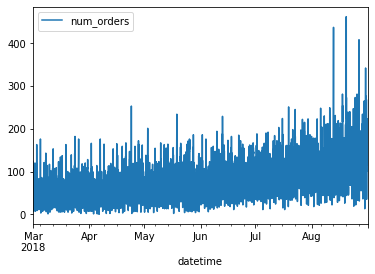

In [7]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.plot()

## Анализ

In [8]:
print('Starting date:',data.index.min())
print('Ending date:',data.index.max())
print('Total time:',data.index.max() - data.index.min())
print()
data.describe()

Starting date: 2018-03-01 00:00:00
Ending date: 2018-08-31 23:00:00
Total time: 183 days 23:00:00



,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Минимальное количество заказов 0, максимальное 462.

Данные собраны за 183 дня и 23 часа.

<AxesSubplot:xlabel='datetime'>

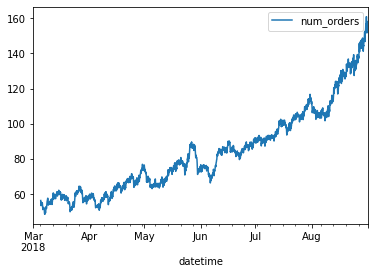

In [9]:
# Добавем столбец 'rolling_mean' скользящее среднее с размером окна, равным 100. 
data.rolling(100).mean().plot()

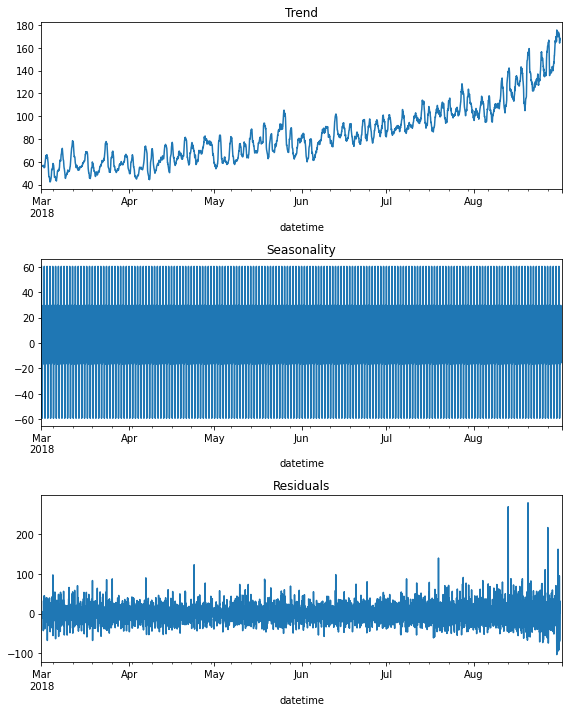

In [10]:
# Разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(data)

plt.figure(figsize=(8, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) 

plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) 

plt.title('Residuals')
plt.tight_layout()

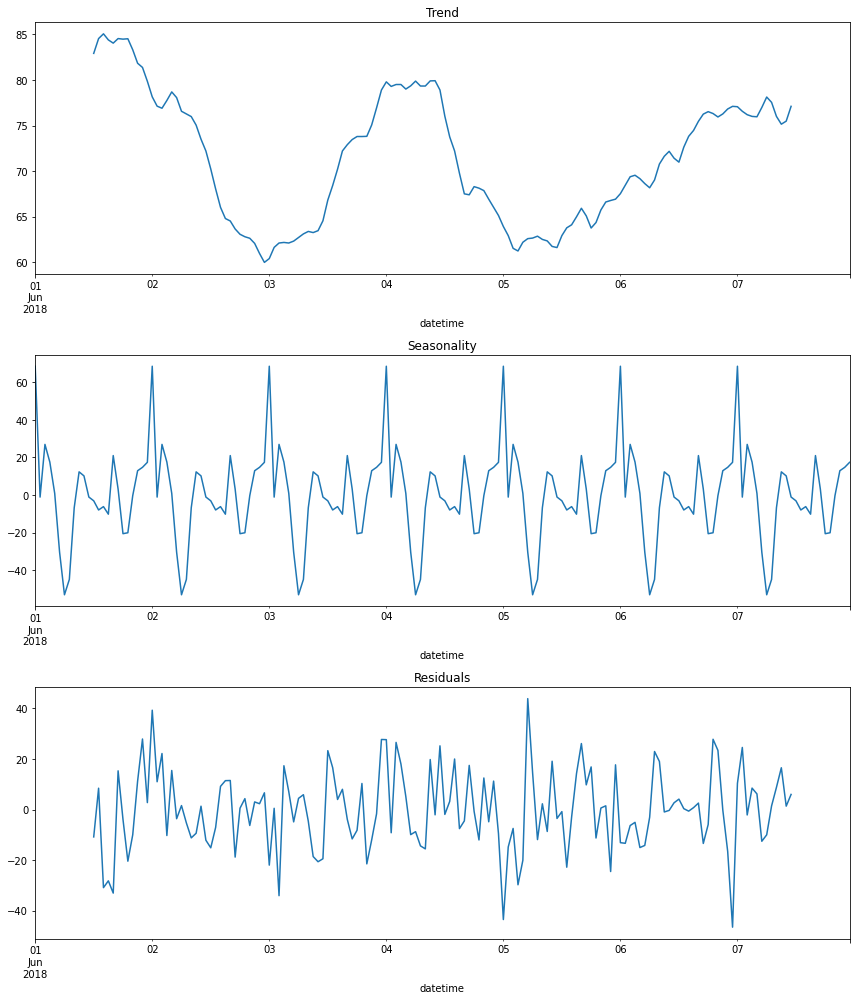

In [11]:
# Посмотрим интревал за неделю
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-07'])

plt.figure(figsize=(12, 14))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()


Явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

<AxesSubplot:xlabel='datetime'>

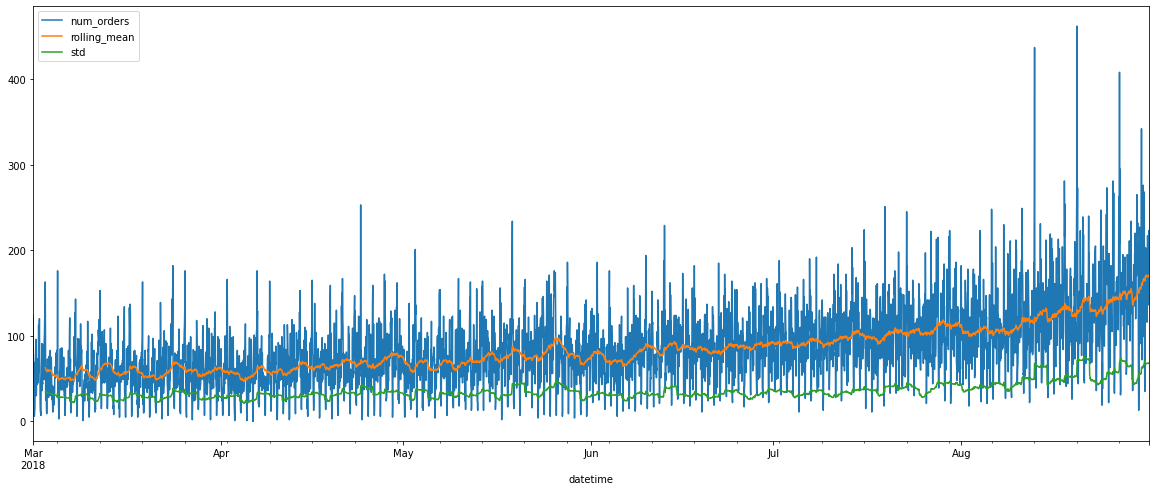

In [12]:
data_plot = data.copy()
data_plot['rolling_mean'] = data_plot.rolling(50).mean()
data_plot['std'] = data_plot['num_orders'].rolling(50).std()
data_plot.plot(figsize=(20, 8))

<AxesSubplot:xlabel='datetime'>

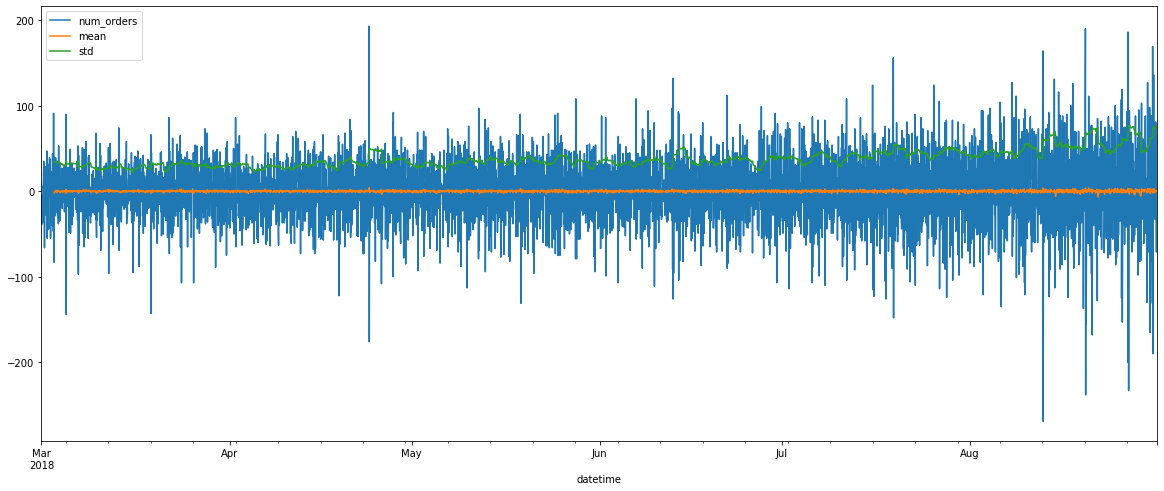

In [13]:
data_shift = data - data.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(50).mean()
data_shift['std'] = data_shift['num_orders'].rolling(50).std()
data_shift.plot(figsize=(20, 8))

Вывод:
На этом этапе проведен анализ данных. Методом декомпозиции были выделены следующие аспекты:

За время наблюдений наметился определенный тренд на общее увеличение заказов такси в течение часа, которое скорее всего вызвано ростом компании, поскольку есть гипотеза, что бизнес, связанный с такси не имеет месячной сезонности. 

На графиках явно видна суточная сезонность. Ночью количество заказов стремится к нулю, в то время как вечерний час пик - момент самого сильного спроса на услуги такси.

## Обучение

In [14]:
# Пропишем функцию для создания признаков, а именно день недели, час -"отстающие значения", скользящее среднее:
def features(data_new, max_lag, rolling_mean_size):
    data_new['dayofweek'] = data_new.index.dayofweek
    data_new['hour'] = data_new.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    data_new = data_new.dropna()

In [15]:
# Применим функцию с лагом до 24 часов и 100-м скользящим средним
features(data, 24, 100)

In [16]:
data = data.dropna()

In [17]:
# Проверим пропуски
print(data.isna().sum())

num_orders      0
dayofweek       0
hour            0
lag_1           0
lag_2           0
lag_3           0
lag_4           0
lag_5           0
lag_6           0
lag_7           0
lag_8           0
lag_9           0
lag_10          0
lag_11          0
lag_12          0
lag_13          0
lag_14          0
lag_15          0
lag_16          0
lag_17          0
lag_18          0
lag_19          0
lag_20          0
lag_21          0
lag_22          0
lag_23          0
lag_24          0
rolling_mean    0
dtype: int64


In [18]:
# Посмотрим данные:
data.head()

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,0,4,51.0,32.0,176.0,86.0,68.0,83.0,75.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,0,5,34.0,51.0,32.0,176.0,86.0,68.0,83.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,0,6,16.0,34.0,51.0,32.0,176.0,86.0,68.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,0,7,3.0,16.0,34.0,51.0,32.0,176.0,86.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,0,8,14.0,3.0,16.0,34.0,51.0,32.0,176.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [20]:
# Функцию для расчета метрики RMSE:
def rmse(test,predict):
    return ((mean_squared_error(test,predict))**0.5).round(2)

In [22]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)

model_lr = LinearRegression()

model_lr.fit(features_train, target_train)
train_pred = model_lr.predict(features_train)

RMSE_lr = cross_val_score(model_lr, features_train, target_train,scoring='neg_root_mean_squared_error', cv=cv).mean()
print(RMSE_lr)

-28.412402437142486


In [28]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)

model_forest=RandomForestRegressor(random_state=12345, n_estimators=100)
model_forest.fit(features_train, target_train)
prediction_forest=model_forest.predict(features_train)

param_grid = { 'n_estimators': range(10, 50, 10),
                     'max_depth': range(1, 10, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }

scorer = make_scorer(rmse, greater_is_better=False)

clf = RandomForestRegressor()

grid_rf = GridSearchCV(clf, param_grid, scoring=scorer, cv=cv)
grid_rf.fit(features_train, target_train)
RMSE_rf = grid_rf.best_score_
print(RMSE_rf)

-27.139999999999997


In [29]:
cv = TimeSeriesSplit(n_splits=3).split(features_train)

model_cat = CatBoostRegressor(n_estimators=1000, random_state=12345, verbose=100)
model_cat.fit(features_train, target_train, eval_set=(features_train,target_train))

params_cat = {
    'learning_rate': [0.1,0.4],
    'depth': [4, 10],
    }

grid_cat = GridSearchCV(estimator=model_cat,param_grid = params_cat, scoring='neg_root_mean_squared_error', cv=cv)
grid_cat.fit(features_train, target_train)
RMSE_cat = grid_cat
print(grid_cat.best_score_)

Learning rate set to 0.06301
0:	learn: 37.5897758	test: 37.5897758	best: 37.5897758 (0)	total: 6.35ms	remaining: 6.34s
100:	learn: 21.3046924	test: 21.3046924	best: 21.3046924 (100)	total: 512ms	remaining: 4.55s
200:	learn: 18.6100829	test: 18.6100829	best: 18.6100829 (200)	total: 1.01s	remaining: 4.03s
300:	learn: 16.5975995	test: 16.5975995	best: 16.5975995 (300)	total: 1.52s	remaining: 3.53s
400:	learn: 15.2268718	test: 15.2268718	best: 15.2268718 (400)	total: 2.03s	remaining: 3.04s
500:	learn: 14.0187063	test: 14.0187063	best: 14.0187063 (500)	total: 2.61s	remaining: 2.6s
600:	learn: 12.9028673	test: 12.9028673	best: 12.9028673 (600)	total: 3.13s	remaining: 2.08s
700:	learn: 11.9564825	test: 11.9564825	best: 11.9564825 (700)	total: 3.64s	remaining: 1.55s
800:	learn: 11.1119204	test: 11.1119204	best: 11.1119204 (800)	total: 4.19s	remaining: 1.04s
900:	learn: 10.3431991	test: 10.3431991	best: 10.3431991 (900)	total: 4.71s	remaining: 518ms
999:	learn: 9.7101051	test: 9.7101051	best: 9

In [30]:
RMSE_cat = grid_cat
print(grid_cat.best_score_)

-26.344794142201238


## Тестирование

In [31]:
predict_lr_t=model_lr.predict(features_test)
rmse_lr_t = np.sqrt(mean_squared_error(target_test, predict_lr_t))
print(rmse_lr_t)

45.1744169554933


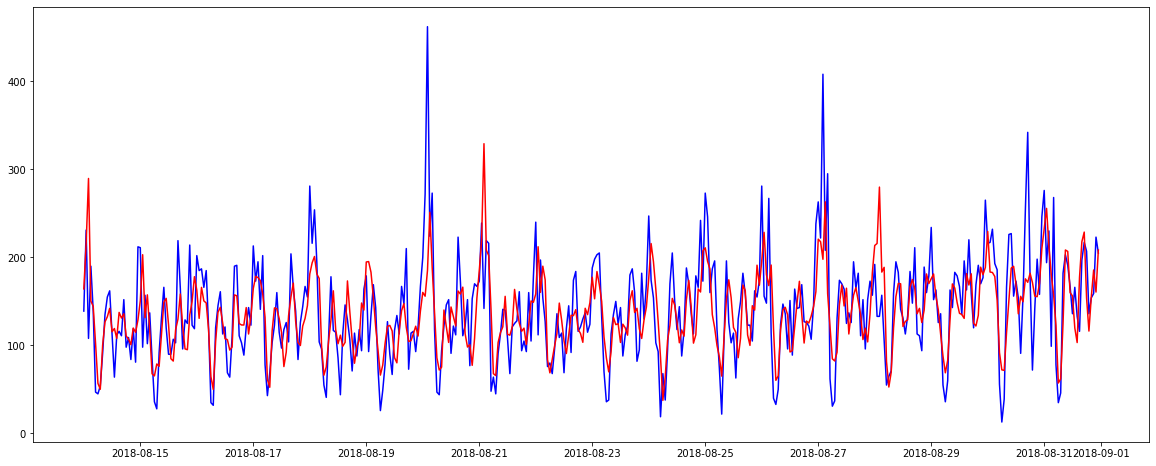

In [40]:
plt.figure(figsize=(20,8))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predict_lr_t,
         'r-')

In [32]:
predict_rf_t=grid_rf.predict(features_test)
rmse_rf_t = np.sqrt(mean_squared_error(target_test, predict_rf_t))
print(rmse_rf_t)

44.57730728832208


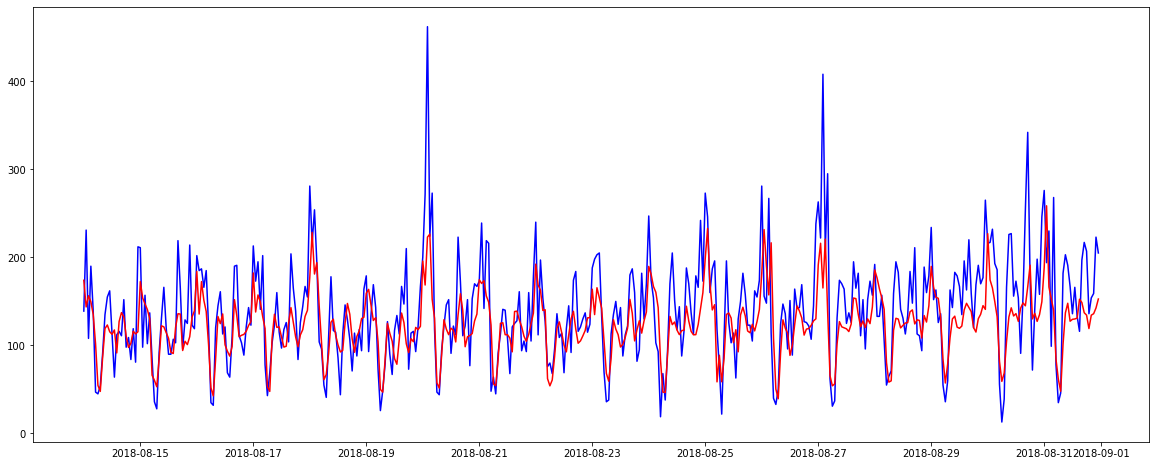

In [43]:
plt.figure(figsize=(20,8))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predict_rf_t,
         'r-')

In [33]:
predict_cat_t=grid_cat.predict(features_test)
rmse_cat_t = np.sqrt(mean_squared_error(target_test, predict_cat_t))
print(rmse_cat_t)

40.524137950731514


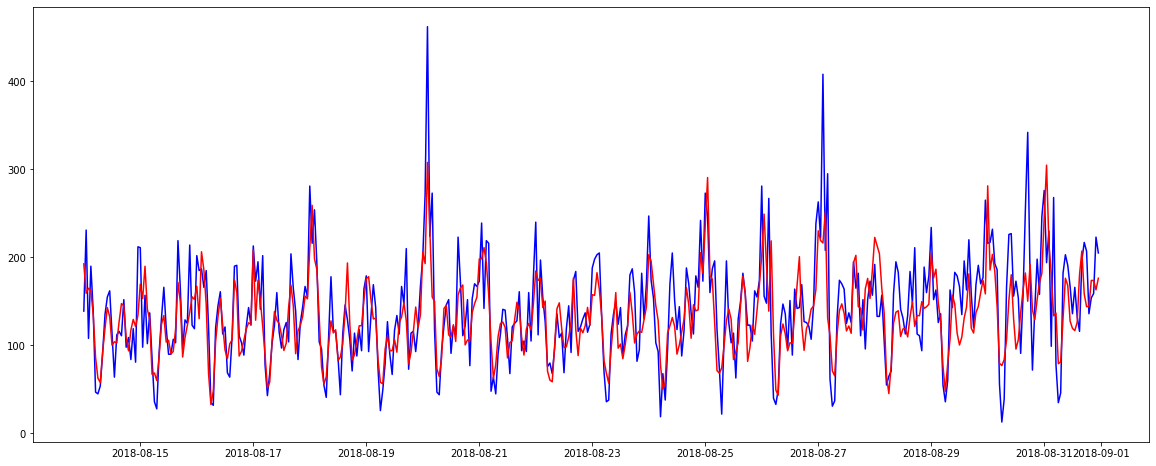

In [44]:
plt.figure(figsize=(20,8))
plt.plot(target_test.index, 
         target_test, 
         'b-', 
         target_test.index, 
         predict_cat_t,
         'r-')

# Вывод:

Мы использовали технологию градиетного бустинга в моделе CatBoostRegressor, и сравнили её с базовыми моделями LinearRegression и RandomForestRegressor

Таким образом для компании "Чётенькое такси" рекомендую модель CatBoostRegressor, т.к. RMSE = 40.524137950731514